## In Face FW for Neural Networks - 2 layers

This notebook implements our algorithm for a one layer feed forward neural network

## Preliminary (packages, auxiliary functions)

In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [2]:
def sigmoid(u):
    return(1/(1+np.exp(-u)))

In [3]:
def sigmoid_prime(u):
    return(1/(4*(np.cosh(u/2))**2))

In [4]:
def mat2vec(A):
    res = np.array([])
    n,p = np.shape(A)
    for i in range(n):
        res = np.concatenate((res,A[i,:]),axis=0)
    return(res)


            
        

In [5]:
mat2vec(np.identity(3))

array([1., 0., 0., 0., 1., 0., 0., 0., 1.])

In [6]:
def vec2mat(a,n,p):
    res = np.zeros((n,p))
    for i in range(n):
        res[i,:]=a[(i*p):((i+1)*p)]
    return(res)
    


In [7]:
vec2mat(np.array([1., 0., 0., 0., 1., 0., 0., 0., 1.,1,2,3]),4,3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 2., 3.]])

In [8]:
def lipschitz(X,Y,k0,k1,activation):
    '''returns the array of lipschitz constants'''
    
    


## Loss function (MSE)

In [9]:
def loss(W0,W1,X,Y,sigma):
    n,p = np.shape(X)
    _,q = np.shape(Y)
    k1,k0 = np.shape(W0)
    k2,_ = np.shape(W1)
    res = 0
    for i in range(n):
        loss_i = sigma(np.matmul(W0,X[i,:]))
        loss_i = np.linalg.norm(Y[i,:] - sigma(np.matmul(W1,loss_i)))**2
        res+=loss_i
    return((0.5*res)/n)
    

In [10]:
W0 = np.array([[1],[2]])
W1 = np.array([[3,4],[5,6],[7,8]])
X = np.array([[-1]])
Y = np.array([[9,10,11]])

In [11]:
#test 
# Y = np.array([np.matmul(np.ones((3,2)),[10,11]),np.matmul(np.ones((3,2)),[12,13])])
loss(W0,W1,X,Y,sigmoid)
#tested with TI nspire

125.83837434060536

## Gradient

In [12]:
def gradient(W0,W1,x,y,sigma, sigma_prime):
    
#     print(loss(W,np.array([x]),np.array([y]),sigma))
    

    x = np.array(x)
    y=np.array(y)
    
    k1,k0 = np.shape(W0)
    k2,_ = np.shape(W1)
    #print(W @ x.reshape(-1,1))
    
    res = np.zeros((k1*k0+k2*k1,))
    
    #forward pass
    input1 = np.matmul(W0,x)
#     print("input1",input1)
    output1 = sigma(input1)
    input2 = np.matmul(W1,output1)
    output2 = sigma(input2)
    
    #backpropagation
    
    u1 = output2 - y 
#     print("u1",u1)
    
    u2 = np.diag(sigma_prime(input2))
#     print("u2",u2)   
    u3 = np.zeros((k2,k2*k1))

    for i in range(k2):
        u3[i,k1*i:k1*(i+1)] = output1
#     print("u3",u3)    
    delta1 = (u1 @ u2 @ u3)
    res[(k1*k0):] = delta1
    
    #delta2:
    
    delta_o_1 = u1 @ u2 @ W1
    
    v2 = np.diag(sigma_prime(input1))
    
    v3 = np.zeros((k1,k1*k0))

    for i in range(k1):
        v3[i,k0*i:k0*(i+1)] = x
    
    res[:(k1*k0)] = delta_o_1 @ v2 @ v3
    
    return(res)

In [13]:
#test
gradient(np.ones((2,2)),0.5*np.ones((1,2)),[4,-2],[-1],sigmoid,sigmoid_prime)
# np.matmul(np.identity(2),[1,2])
# tested with an extraneous calculator for the sigmoid case

array([ 0.07425421, -0.0371271 ,  0.07425421, -0.0371271 ,  0.31146136,
        0.31146136])

## Frank Wolfe step Implementation

In [14]:
def create_extremal_points(k0,k1,k2,delta):
    extremal_points = [np.zeros((k0*k1 + k1*k2,)) for i in range(2*k0*k1+2*k1*k2)]
    for i in range(2*k0*k1+2*k1*k2):
        extremal_points[i][int(i/2)]=(-1)**i*delta
    return(extremal_points)


In [15]:
create_extremal_points(2,2,1,0.5)

[array([0.5, 0. , 0. , 0. , 0. , 0. ]),
 array([-0.5,  0. ,  0. ,  0. ,  0. ,  0. ]),
 array([0. , 0.5, 0. , 0. , 0. , 0. ]),
 array([ 0. , -0.5,  0. ,  0. ,  0. ,  0. ]),
 array([0. , 0. , 0.5, 0. , 0. , 0. ]),
 array([ 0. ,  0. , -0.5,  0. ,  0. ,  0. ]),
 array([0. , 0. , 0. , 0.5, 0. , 0. ]),
 array([ 0. ,  0. ,  0. , -0.5,  0. ,  0. ]),
 array([0. , 0. , 0. , 0. , 0.5, 0. ]),
 array([ 0. ,  0. ,  0. ,  0. , -0.5,  0. ]),
 array([0. , 0. , 0. , 0. , 0. , 0.5]),
 array([ 0. ,  0. ,  0. ,  0. ,  0. , -0.5])]

In [16]:
def fw_step(W0,W1,L,df,delta,Gtilde_1=np.inf,mode="basis"):
    '''
    - mode: basis or linprog
    '''
#     df = gradient()

    w0 = mat2vec(W0)
    w1 = mat2vec(W1)
    
    w = np.concatenate((w0,w1),axis=0)
    
    k1,k0 = np.shape(W0)
    k2,_ = np.shape(W1)
#     if mode == "linprog":
        
#         A_ub,b_ub,A_eq,b_eq,c = create_matrix_fw(k0,k1,delta,df)
#         print(A_ub,b_ub,A_eq,b_eq,c)
#         print(A_ub.shape,b_ub.shape,A_eq.shape,b_eq.shape,c.shape)

#         x_tilde=linprog(c=c,A_ub=A_ub,b_ub=b_ub,A_eq=A_eq,b_eq=b_eq,bounds=[-np.inf,np.inf])["x"]
#         w_tilde = x_tilde[2::3]
    

    
    if mode == "basis":
        extremal_points = create_extremal_points(k0,k1,k2,delta)
#         print("extremal_points: ", extremal_points)
        g = lambda x: np.inner(df,x)
        candidate_objectives = list(map(g,extremal_points))
        winner_index = np.argmin(candidate_objectives)
        w_tilde = extremal_points[winner_index]
        print("w_tilde",w_tilde)
        
    #return(w_tilde)
    
#     w_tilde = np.array([X_tilde])
    print("w_tilde",w_tilde)
    #fw gap
    G = df.T @ (w - w_tilde)
    G_tilde = min(G,Gtilde_1)
    
    #curvature Ck
    C = L * np.linalg.norm(w-w_tilde)**2
    
    print("Ck: ",C)
    
    #time step
    alpha = min(G/C,1)
    wiplus1 = w + alpha*(w_tilde-w)
    
    if G <= C:
        theta = G**2/(2*C)
    else:
        theta = G/2
    
    return(vec2mat(wiplus1[:k0*k1],k1,k0),vec2mat(wiplus1[k0*k1:],k2,k1),G_tilde,theta)


In [17]:
fw_step(np.zeros((1,1)),np.zeros((1,1)),1,np.ones((2*1,))*0.5,0.1,mode="basis")
# should work with 2 layers!!

w_tilde [-0.1  0. ]
w_tilde [-0.1  0. ]
Ck:  0.010000000000000002


(array([[-0.1]]), array([[0.]]), 0.05, 0.025)

## In Face Step Implementation

In [18]:
def create_matrix_inface(W,delta,df):
    '''
    creates matrix to have the following LP problem:
    max df * x
    s.t. x in feasible region 
         x in minimal face containing W
    '''
    w0 = mat2vec(W0)
    w1 = mat2vec(W1)
    
    w = mat2vec(W)
    
    w_is_zero = w==0
    
    num_zero = sum(w_is_zero)
    
    zero_indices = [i for i,x in enumerate(w) if x==0]
#     print(zero_indices)
    
    A_ub,b_ub,A_eq,b_eq,c = create_matrix_fw(k0,k1,delta,df)
    
    inface_A_eq = np.zeros((num_zero,np.shape(A_eq)[1]))
    
    for i in range(num_zero):
        index = zero_indices[i]
        inface_A_eq[i,3*index:3*(index+1)] = [0,0,1]
        
    A_eq = np.concatenate((A_eq, inface_A_eq),axis=0)
    
    b_eq = np.concatenate((b_eq,np.zeros(num_zero,)))
    
    return(A_ub,b_ub,A_eq,b_eq,-c)
    

In [19]:
def find_inface_dir(W0,W1,delta,df, mode = "basis"):
    
    w0 = mat2vec(W0)
    w1 = mat2vec(W1)
    
    w = np.concatenate((w0,w1),axis=0)
    
    k1,k0 = np.shape(W0)
    k2,_ = np.shape(W1)
    print(k0,k1,k2)
    
        
    if mode == "linprog":
    

        w_hat = linprog(c=c,A_ub=A_ub,b_ub=b_ub,A_eq=A_eq,b_eq=b_eq,bounds=[-np.inf,np.inf])["x"]

        w_hat = w_hat[2::3]
#     print(W)
    if mode == "basis":
        extremal_points = create_extremal_points(k0,k1,k2,delta)
        I_plus = (w>0)
        I_zero = (w == 0)
        I_minus = (w<0)
        
        IF_extremal_points = []
        
        #take only in face extremal points
        for p in extremal_points:
#             print(I_plus)
#             print(extremal_points)
            b1 = np.prod(p[I_plus]>=0)
            b2 = np.prod(p[I_zero] == 0)
            b3 = np.prod(p[I_minus] <= 0)
            if b1 + b2 + b3 == 3:
                IF_extremal_points.append(p)
        
        g = lambda x: np.inner(df,x)
        candidate_objectives = list(map(g,IF_extremal_points))
        winner_index = np.argmin(candidate_objectives)
        w_hat = IF_extremal_points[winner_index]
        print(w_hat)
        
    res = w_hat - w
    
    return(vec2mat(res[:k0*k1],k1,k0),vec2mat(res[k0*k1:],k2,k1))
    
    
    
    

In [20]:
#test
# print(find_inface_dir(np.array([[0.25],[0.75],[0]]),1,np.array([1,0,0])))
find_inface_dir(np.array([[0.3,0.7]]),np.array([[4]]),1,np.array([1,1,0]))
#tested with AMPL for 2 layers (should work!!)

2 1 1
[0. 0. 1.]


(array([[-0.3, -0.7]]), array([[-3.]]))

## Main Function

In [21]:
def fw_noncvx(X,Y,delta,W0,W1,T,gamma_1,gamma_2, activation="linear",sigma=None,sigma_prime=None,k0=None,k1=None,L=None):
    '''
    Input:
    X: n x p array 
    Y: n x q array (q dimension of output layer)
    W0,W1: initial iterate
    
    '''
    
    if(activation == "linear") and sigma is None:
        sigma = lambda x: x
        sigma_prime = lambda x: np.ones(np.shape(x))
    if(activation == "sigmoid") and sigma is None:
        sigma = sigmoid
        sigma_prime = sigmoid_prime
        
#     W = np.zeros((k1,k0))
#     i,j = np.random.randint(0,k1-1,1), np.random.randint(0,k0-1,1)
#     W[i,j]=delta
#     L = lipschitz(k0,k1)

    k1,k0 = np.shape(W0)
    
    k2,_ = np.shape(W1)

    print("Begin Iteration ",0)
#     L=10
    n,p = np.shape(X)
    _,q = np.shape(Y)
    
    print(n,p,q)
    
    df = np.zeros((k0*k1+k1*k2,))
    for i in range(n):
        df+=gradient(W0,W1,X[i,:],Y[i,:],sigma, sigma_prime)
    df/=n
    
    print("Gradient: ", df)
    print("Initial Loss", loss(W0,W1,X,Y,sigma))
    
    W0, W1, G_tilde, theta = fw_step(W0,W1,L,df,delta)
    
    print(W0,W1,G_tilde,theta)
    
    #loss function
    f = lambda W0,W1: loss(W0,W1,X,Y,sigma)
    
    objectives=[f(W0,W1)]
    
    for k in range(1,T):
        print("Begin Iteration ",k)
        
        #Compute gradient
        df = np.zeros((k0*k1+k1*k2,))
        for i in range(n):
            df+=gradient(W0,W1,X[i,:],Y[i,:],sigma, sigma_prime)
        df/=n
        print("Gradient: ", df)
        #Inface direction
        d0,d1 = find_inface_dir(W0,W1,delta,df)
        
        
        #alpha_stop = find_alpha_stop(W,delta,df,d)
        
        alpha_stop = 1
        
        #(a) Go to lower dimensional face
        W_B0 = W0 + alpha_stop*d0
        W_B1 = W1 + alpha_stop*d1
        
        beta = np.random.uniform()*alpha_stop
        
        W_A0 = W0 + beta*d0
        W_A1 = W1 + beta*d1
        
        if(f(W_B0,W_B1) <= f(W0,W1) - gamma_1*theta):
            print("--(a)--")
            W0,W1 = W_B0,W_B1
            G_tilde = G_tilde
            theta = theta
        
        #(b) Stay in current face
        elif(f(W_A0,W_A1) <= f(W0,W1) - gamma_2*theta):
            print("--(b)--")
            W0,W1 = W_A0,W_A1
            G_tilde = G_tilde
            theta = theta
        
        #(c) Regular FW step
        else:
            print("--FW--")
            W0, W1, G_tilde, theta = fw_step(W0,W1,L,df,delta,Gtilde_1=G_tilde)
        print("W: ", W0,W1)
        if G_tilde==0:
            print("Reached a local optimum!")
            break
        objectives.append(f(W0,W1))
    return(W0,W1,objectives)

## Numerical Experiments

Initialize random training features

In [22]:
np.random.seed(8)
X = np.random.rand(10,2)
X


array([[0.8734294 , 0.96854066],
       [0.86919454, 0.53085569],
       [0.23272833, 0.0113988 ],
       [0.43046882, 0.40235136],
       [0.52267467, 0.4783918 ],
       [0.55535647, 0.54338602],
       [0.76089558, 0.71237457],
       [0.6196821 , 0.42609177],
       [0.28907503, 0.97385524],
       [0.33377405, 0.21880106]])

Computing the labels in the features, using sigmoid and sparse ground truth coefficients. Initialize at another weight vector.

In [23]:
W_star0 = np.array([[1,0],[0,0]])
W_star1 = np.array([[1,0]])
Y = sigmoid(X @ W_star0.T)
Y = sigmoid(Y @ W_star1.T)
print(Y)
delta = 1
W0 = np.array([[0,1],[0,0]])
W1 = np.array([[1,0]])
T=200
gamma_1 = 0.1
gamma_2 = 0.1

[[0.66939694]
 [0.66920201]
 [0.63597134]
 [0.64702452]
 [0.65198432]
 [0.65370778]
 [0.66408414]
 [0.65704342]
 [0.63917142]
 [0.64168324]]


In [24]:
_,_,l1 = fw_noncvx(X,Y,delta,W0,W1,T,gamma_1,gamma_2,L=0.5,sigma = sigmoid, sigma_prime = sigmoid_prime)

Begin Iteration  0
10 2 1
Gradient:  [-1.02621293e-04  6.64057432e-05  0.00000000e+00  0.00000000e+00
 -9.36116887e-05 -1.83320814e-04]
Initial Loss 9.163470707801094e-05
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4999999999999998
[[0.         0.99989592]
 [0.         0.        ]] [[9.99895923e-01 1.04076579e-04]] 0.0001561148683475828 8.123950706394372e-09
Begin Iteration  1
Gradient:  [-1.02780873e-04  6.62252351e-05 -1.00516894e-08  1.06564000e-08
 -9.44501955e-05 -1.83954229e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--(b)--
W:  [[0.         0.93409438]
 [0.         0.        ]] [[0.93409438 0.06590562]]
Begin Iteration  2
Gradient:  [-1.96054158e-04 -4.07598028e-05 -1.42441302e-05 -1.77647714e-06
 -6.07521059e-04 -5.76763070e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.44060970992881493
W:  [[0.        0.9341708]
 [0.        0.       ]] [[0.93408899 0.06591101]]
Begin Iteration  3
Gradient:  [-1.96000967e-04 -4.070808

w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.4425272752559497
W:  [[0.         0.93619871]
 [0.         0.        ]] [[0.93394591 0.06605409]]
Begin Iteration  30
Gradient:  [-1.94590963e-04 -3.93374384e-05 -1.41660416e-05 -1.66213057e-06
 -6.00521346e-04 -5.71279273e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.4425971510663994
W:  [[0.         0.93627252]
 [0.         0.        ]] [[0.93394071 0.06605929]]
Begin Iteration  31
Gradient:  [-1.94539695e-04 -3.92876163e-05 -1.41632956e-05 -1.65811263e-06
 -6.00275842e-04 -5.71087025e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.4426669460187316
W:  [[0.         0.93634624]
 [0.         0.        ]] [[0.9339355 0.0660645]]
Begin Iteration  32
Gradient:  [-1.94488495e-04 -3.92378606e-05 -1.41605527e-05 -1.65409918e-06
 -6.00030643e-04 -5.70895022e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck

Gradient:  [-1.93279590e-04 -3.80633621e-05 -1.40955937e-05 -1.55911165e-06
 -5.94236344e-04 -5.66359521e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.4443858196986783
W:  [[0.         0.93816001]
 [0.         0.        ]] [[0.93380753 0.06619247]]
Begin Iteration  57
Gradient:  [-1.93230038e-04 -3.80152323e-05 -1.40929231e-05 -1.55520895e-06
 -5.93998641e-04 -5.66173529e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.44445354569550255
W:  [[0.        0.9382314]
 [0.        0.       ]] [[0.93380249 0.06619751]]
Begin Iteration  58
Gradient:  [-1.93180551e-04 -3.79671663e-05 -1.40902554e-05 -1.55131061e-06
 -5.93761232e-04 -5.65987773e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.4445211933853616
W:  [[0.         0.93830271]
 [0.         0.        ]] [[0.93379746 0.06620254]]
Begin Iteration  59
Gradient:  [-1.93131128e-04 -3.

--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.4461872055149742
W:  [[0.         0.94005709]
 [0.         0.        ]] [[0.93367368 0.06632632]]
Begin Iteration  84
Gradient:  [-1.91916269e-04 -3.67395225e-05 -1.40218902e-05 -1.45147118e-06
 -5.87690709e-04 -5.61239888e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.4462528494889428
W:  [[0.         0.94012615]
 [0.         0.        ]] [[0.93366881 0.06633119]]
Begin Iteration  85
Gradient:  [-1.91868493e-04 -3.66931426e-05 -1.40192987e-05 -1.44768897e-06
 -5.87461105e-04 -5.61060381e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.4463184176237194
W:  [[0.         0.94019513]
 [0.         0.        ]] [[0.93366394 0.06633606]]
Begin Iteration  86
Gradient:  [-1.91820778e-04 -3.66468237e-05 -1.40167099e-05 -1.44391099e-06
 -5.87231785e-04 -5.60881102e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 

Gradient:  [-1.90555618e-04 -3.54189973e-05 -1.39478563e-05 -1.34348957e-06
 -5.81145985e-04 -5.56125178e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.44812389640977646
W:  [[0.         0.94209241]
 [0.         0.        ]] [[0.93353008 0.06646992]]
Begin Iteration  114
Gradient:  [-1.90509605e-04 -3.53743540e-05 -1.39453444e-05 -1.33982831e-06
 -5.80924455e-04 -5.55952125e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.44818730384181577
W:  [[0.         0.94215897]
 [0.         0.        ]] [[0.93352538 0.06647462]]
Begin Iteration  115
Gradient:  [-1.90463652e-04 -3.53297692e-05 -1.39428352e-05 -1.33617115e-06
 -5.80703197e-04 -5.55779290e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.44825063808225907
W:  [[0.         0.94222545]
 [0.         0.        ]] [[0.93352069 0.06647931]]
Begin Iteration  116
Gradient:  [-1.9041775

Gradient:  [-1.89333904e-04 -3.42339287e-05 -1.38809763e-05 -1.24606219e-06
 -5.75259369e-04 -5.51528367e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.4498104582293051
W:  [[0.         0.94386128]
 [0.         0.        ]] [[0.93340528 0.06659472]]
Begin Iteration  141
Gradient:  [-1.89289468e-04 -3.41908364e-05 -1.38785365e-05 -1.24251011e-06
 -5.75045078e-04 -5.51361094e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.44987191957085837
W:  [[0.         0.94392568]
 [0.         0.        ]] [[0.93340073 0.06659927]]
Begin Iteration  142
Gradient:  [-1.89245089e-04 -3.41478003e-05 -1.38760993e-05 -1.23896202e-06
 -5.74831051e-04 -5.51194030e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.44993331002168746
W:  [[0.      0.94399]
 [0.      0.     ]] [[0.93339619 0.06660381]]
Begin Iteration  143
Gradient:  [-1.89200767e-04 -3.4104

 [0.        0.       ]] [[0.9332495 0.0667505]]
Begin Iteration  176
Gradient:  [-1.87769666e-04 -3.27174664e-05 -1.37947824e-05 -1.12066500e-06
 -5.67708236e-04 -5.45636716e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.4519789974367103
W:  [[0.        0.9461308]
 [0.        0.       ]] [[0.93324515 0.06675485]]
Begin Iteration  177
Gradient:  [-1.87727238e-04 -3.26763484e-05 -1.37924357e-05 -1.11725354e-06
 -5.67503203e-04 -5.45476819e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.452037958757395
W:  [[0.         0.94619243]
 [0.         0.        ]] [[0.9332408 0.0667592]]
Begin Iteration  178
Gradient:  [-1.87684865e-04 -3.26352837e-05 -1.37900915e-05 -1.11384591e-06
 -5.67298420e-04 -5.45317123e-04]
2 2 1
[0. 0. 0. 0. 1. 0.]
--FW--
w_tilde [0. 0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 0. 1. 0.]
Ck:  0.45209685213906725
W:  [[0.         0.94625399]
 [0.         0.        ]] [[0.93323

In [25]:
_,_,l2 = fw_noncvx(X,Y,delta,W0,W1,T,gamma_1 = np.inf,gamma_2=np.inf,L=0.5,sigma = sigmoid, sigma_prime = sigmoid_prime)

Begin Iteration  0
10 2 1
Gradient:  [-1.02621293e-04  6.64057432e-05  0.00000000e+00  0.00000000e+00
 -9.36116887e-05 -1.83320814e-04]
Initial Loss 9.163470707801094e-05
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4999999999999998
[[0.         0.99989592]
 [0.         0.        ]] [[9.99895923e-01 1.04076579e-04]] 0.0001561148683475828 8.123950706394372e-09
Begin Iteration  1
Gradient:  [-1.02780873e-04  6.62252351e-05 -1.00516894e-08  1.06564000e-08
 -9.44501955e-05 -1.83954229e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4996877865112064
W:  [[0.        0.9997921]
 [0.        0.       ]] [[9.99792104e-01 2.07896091e-04]]
Begin Iteration  2
Gradient:  [-1.02940022e-04  6.60452076e-05 -2.01185221e-08  2.12433390e-08
 -9.52865483e-05 -1.84586043e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4993763765569563
W:  [[0.         0.99968854]
 [0.         0.       

Gradient:  [-1.08103531e-04  6.02001298e-05 -3.69831738e-07  3.42552117e-07
 -1.22483689e-04 -2.05146165e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.489250515972097
W:  [[0.         0.99631515]
 [0.         0.        ]] [[0.99631515 0.00368485]]
Begin Iteration  37
Gradient:  [-1.08248381e-04  6.00360434e-05 -3.80293033e-07  3.50940639e-07
 -1.23248388e-04 -2.05724654e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4889658300077768
W:  [[0.         0.99622015]
 [0.         0.        ]] [[0.99622015 0.00377985]]
Begin Iteration  38
Gradient:  [-1.08392844e-04  5.98723885e-05 -3.90762052e-07  3.59272557e-07
 -1.24011143e-04 -2.06301695e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4886818692004475
W:  [[0.         0.99612537]
 [0.         0.        ]] [[0.99612537 0.00387463]]
Begin Iteration  39
Gradient:  [-1.08536922e-04  

Gradient:  [-1.11882140e-04  5.59175916e-05 -6.54493236e-07  5.50084844e-07
 -1.42463650e-04 -2.20268130e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4818126543773824
W:  [[0.         0.99382991]
 [0.         0.        ]] [[0.99382991 0.00617009]]
Begin Iteration  64
Gradient:  [-1.12016951e-04  5.57647200e-05 -6.65103540e-07  5.57052951e-07
 -1.43177709e-04 -2.20808851e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4815468484654297
W:  [[0.         0.99374098]
 [0.         0.        ]] [[0.99374098 0.00625902]]
Begin Iteration  65
Gradient:  [-1.12151406e-04  5.56122470e-05 -6.75717140e-07  5.63972543e-07
 -1.43889965e-04 -2.21348226e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4812817147321329
W:  [[0.         0.99365227]
 [0.         0.        ]] [[0.99365227 0.00634773]]
Begin Iteration  66
Gradient:  [-1.12285505e-04 

Gradient:  [-1.15525536e-04  5.17841047e-05 -9.52365883e-07  7.27730754e-07
 -1.61791803e-04 -2.34911213e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4746181534406133
W:  [[0.         0.99142002]
 [0.         0.        ]] [[0.99142002 0.00857998]]
Begin Iteration  92
Gradient:  [-1.15650757e-04  5.16419653e-05 -9.63016131e-07  7.33440365e-07
 -1.62457216e-04 -2.35415586e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.474370479350167
W:  [[0.         0.99133695]
 [0.         0.        ]] [[0.99133695 0.00866305]]
Begin Iteration  93
Gradient:  [-1.15775650e-04  5.15001933e-05 -9.73665935e-07  7.39108668e-07
 -1.63120960e-04 -2.35918712e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4741234271659385
W:  [[0.         0.99125409]
 [0.         0.        ]] [[0.99125409 0.00874591]]
Begin Iteration  94
Gradient:  [-1.15900217e-04  

w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4672219075729325
W:  [[0.         0.98893638]
 [0.         0.        ]] [[0.98893638 0.01106362]]
Begin Iteration  123
Gradient:  [-1.19374587e-04  4.74127636e-05 -1.29239275e-06  8.91082157e-07
 -1.82279548e-04 -2.50448415e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4669927395020725
W:  [[0.         0.98885932]
 [0.         0.        ]] [[0.98885932 0.01114068]]
Begin Iteration  124
Gradient:  [-1.19489774e-04  4.72818742e-05 -1.30297389e-06  8.95581483e-07
 -1.82893765e-04 -2.50914465e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4667641426496327
W:  [[0.         0.98878246]
 [0.         0.        ]] [[0.98878246 0.01121754]]
Begin Iteration  125
Gradient:  [-1.19604662e-04  4.71513200e-05 -1.31355118e-06  9.00046487e-07
 -1.83506453e-04 -2.51379369e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1

Begin Iteration  155
Gradient:  [-1.22916575e-04  4.33859824e-05 -1.62865139e-06  1.01898604e-06
 -2.01196243e-04 -2.64808542e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4599526772002884
W:  [[0.         0.98648925]
 [0.         0.        ]] [[0.98648925 0.01351075]]
Begin Iteration  156
Gradient:  [-1.23022616e-04  4.32653645e-05 -1.63906726e-06  1.02248059e-06
 -2.01763529e-04 -2.65239396e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4597415642598033
W:  [[0.         0.98641809]
 [0.         0.        ]] [[0.98641809 0.01358191]]
Begin Iteration  157
Gradient:  [-1.23128386e-04  4.31450530e-05 -1.64947668e-06  1.02594667e-06
 -2.02329412e-04 -2.65669197e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4595309737001119
W:  [[0.        0.9863471]
 [0.        0.       ]] [[0.9863471 0.0136529]]
Begin Iteration  158
Gradient: 

Begin Iteration  188
Gradient:  [-1.26276220e-04  3.95627567e-05 -1.96860300e-06  1.12015193e-06
 -2.19196261e-04 -2.78485674e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.453254279642159
W:  [[0.         0.98422886]
 [0.         0.        ]] [[0.98422886 0.01577114]]
Begin Iteration  189
Gradient:  [-1.26373667e-04  3.94518090e-05 -1.97877151e-06  1.12279055e-06
 -2.19719192e-04 -2.78883207e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4530596868087204
W:  [[0.         0.98416312]
 [0.         0.        ]] [[0.98416312 0.01583688]]
Begin Iteration  190
Gradient:  [-1.26470865e-04  3.93411407e-05 -1.98893153e-06  1.12540576e-06
 -2.20240839e-04 -2.79279774e-04]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  1.4528655722110841
W:  [[0.         0.98409753]
 [0.         0.        ]] [[0.98409753 0.01590247]]
Begin Iteration  191
Gradi

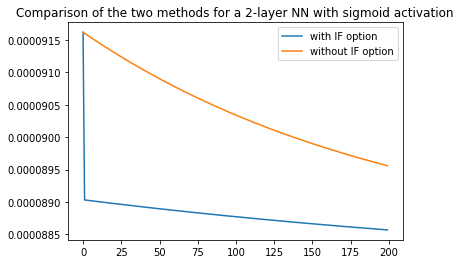

In [26]:
plt.plot(list(range(len(l1))),l1,label = "with IF option")
plt.plot(list(range(len(l2))),l2, label = "without IF option")
plt.legend()
plt.title("Comparison of the two methods for a 2-layer NN with sigmoid activation")
plt.savefig("2layers_exp1.png")

Repeat with another initialization point

In [27]:
W_star0 = np.array([[1,0],[0,0]])
W_star1 = np.array([[1,0]])
Y = sigmoid(X @ W_star0.T)
Y = sigmoid(Y @ W_star1.T)
print(Y)
delta = 1
W0 = np.array([[0,1],[1,0]])
W1 = np.array([[1,1]])
T=200
gamma_1 = 0.1
gamma_2 = 0.1

[[0.66939694]
 [0.66920201]
 [0.63597134]
 [0.64702452]
 [0.65198432]
 [0.65370778]
 [0.66408414]
 [0.65704342]
 [0.63917142]
 [0.64168324]]


In [28]:
_,_,l1 = fw_noncvx(X,Y,delta,W0,W1,T,gamma_1,gamma_2,L=0.5,sigma = sigmoid, sigma_prime = sigmoid_prime)

Begin Iteration  0
10 2 1
Gradient:  [0.002657   0.00253813 0.00263095 0.00261617 0.01351994 0.01358229]
Initial Loss 0.00791303660085643
w_tilde [ 0.  0.  0.  0.  0. -1.]
w_tilde [ 0.  0.  0.  0.  0. -1.]
Ck:  3.5000000000000004
[[0.         0.98689897]
 [0.98689897 0.        ]] [[0.98689897 0.97379794]] 0.0458536058083792 0.0003003647379471753
Begin Iteration  1
Gradient:  [0.00256772 0.00245827 0.00250985 0.0024991  0.01317682 0.01323271]
2 2 1
[0. 1. 0. 0. 0. 0.]
--(b)--
W:  [[0.         0.99173791]
 [0.6223823  0.        ]] [[0.6223823  0.61412021]]
Begin Iteration  2
Gradient:  [0.00041017 0.00044001 0.00043184 0.00048285 0.00356328 0.0032428 ]
2 2 1
[0. 0. 1. 0. 0. 0.]
--(b)--
W:  [[0.         0.76083431]
 [0.71030198 0.        ]] [[0.47747475 0.4711363 ]]
Begin Iteration  3
Gradient:  [-0.00024251 -0.00019005 -0.00023666 -0.00018596 -0.00205992 -0.00211727]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.7955383551555132
W:  [[0. 

--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8043333718347276
W:  [[0.         0.76519506]
 [0.7143731  0.        ]] [[0.48021141 0.4681051 ]]
Begin Iteration  29
Gradient:  [-0.00024252 -0.00018957 -0.00023375 -0.00018315 -0.00205028 -0.00210845]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.804683788651693
W:  [[0.         0.7653616 ]
 [0.71452858 0.        ]] [[0.48031592 0.46798933]]
Begin Iteration  30
Gradient:  [-0.00024252 -0.00018955 -0.00023364 -0.00018304 -0.00204991 -0.00210811]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8050340988483262
W:  [[0.         0.76552805]
 [0.71468398 0.        ]] [[0.48042038 0.46787363]]
Begin Iteration  31
Gradient:  [-0.00024253 -0.00018953 -0.00023353 -0.00018294 -0.00204954 -0.00210778]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8053843024063426
W:  [[0.         

Begin Iteration  56
Gradient:  [-0.00024253 -0.00018906 -0.00023079 -0.0001803  -0.00204039 -0.00209942]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8141046821669434
W:  [[0.         0.76982552]
 [0.71869602 0.        ]] [[0.48311734 0.46488641]]
Begin Iteration  57
Gradient:  [-0.00024253 -0.00018904 -0.00023068 -0.00018019 -0.00204003 -0.00209909]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8144521069971807
W:  [[0.         0.76998965]
 [0.71884925 0.        ]] [[0.48322034 0.46477233]]
Begin Iteration  58
Gradient:  [-0.00024253 -0.00018902 -0.00023058 -0.00018009 -0.00203967 -0.00209876]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8147994247289205
W:  [[0.         0.77015369]
 [0.71900239 0.        ]] [[0.48332328 0.4646583 ]]
Begin Iteration  59
Gradient:  [-0.00024253 -0.000189   -0.00023047 -0.00017998 -0.0020393  -0.00209842

w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8248249827862305
W:  [[0.         0.77487385]
 [0.72340905 0.        ]] [[0.4862855  0.46137727]]
Begin Iteration  88
Gradient:  [-0.00024252 -0.00018844 -0.00022737 -0.00017699 -0.00202886 -0.00208889]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8251690806014055
W:  [[0.         0.77503534]
 [0.72355982 0.        ]] [[0.48638685 0.46126502]]
Begin Iteration  89
Gradient:  [-0.00024252 -0.00018842 -0.00022726 -0.00017689 -0.0020285  -0.00208856]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8255130708679823
W:  [[0.         0.77519675]
 [0.72371051 0.        ]] [[0.48648814 0.46115282]]
Begin Iteration  90
Gradient:  [-0.00024252 -0.0001884  -0.00022716 -0.00017679 -0.00202814 -0.00208824]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8258569535727845
W:  [[0.         0.7753

w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8368043329460393
W:  [[0.         0.78047642]
 [0.72863952 0.        ]] [[0.48980149 0.45748287]]
Begin Iteration  123
Gradient:  [-0.00024249 -0.00018776 -0.00022372 -0.00017348 -0.00201645 -0.00207758]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8371446592541326
W:  [[0.         0.78063499]
 [0.72878756 0.        ]] [[0.48990101 0.45737264]]
Begin Iteration  124
Gradient:  [-0.00024249 -0.00018774 -0.00022362 -0.00017338 -0.0020161  -0.00207726]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8374848776007356
W:  [[0.         0.78079349]
 [0.72893553 0.        ]] [[0.49000047 0.45726247]]
Begin Iteration  125
Gradient:  [-0.00024249 -0.00018772 -0.00022352 -0.00017329 -0.00201575 -0.00207694]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8378249879754843
W:  [[0.         0.7

Gradient:  [-0.00024245 -0.00018712 -0.00022048 -0.00017036 -0.0020053  -0.00206742]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8479780440622442
W:  [[0.         0.78566617]
 [0.73348458 0.        ]] [[0.49305841 0.45387542]]
Begin Iteration  156
Gradient:  [-0.00024245 -0.0001871  -0.00022038 -0.00017027 -0.00200496 -0.00206711]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.848314802589455
W:  [[0.         0.78582205]
 [0.73363011 0.        ]] [[0.49315623 0.45376707]]
Begin Iteration  157
Gradient:  [-0.00024245 -0.00018708 -0.00022028 -0.00017017 -0.00200461 -0.00206679]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8486514528536749
W:  [[0.         0.78597784]
 [0.73377556 0.        ]] [[0.49325401 0.45365877]]
Begin Iteration  158
Gradient:  [-0.00024244 -0.00018706 -0.00022018 -0.00017007 -0.00200427 -0.00206648]
2 2 1
[0. 0. 0. 

Gradient:  [-0.0002424  -0.00018652 -0.00021751 -0.00016751 -0.00199502 -0.00205806]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8580336755969417
W:  [[0.         0.79030746]
 [0.73781761 0.        ]] [[0.49597113 0.45064921]]
Begin Iteration  186
Gradient:  [-0.0002424  -0.0001865  -0.00021742 -0.00016742 -0.00199468 -0.00205775]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.858367183114608
W:  [[0.         0.79046093]
 [0.73796089 0.        ]] [[0.49606744 0.45054253]]
Begin Iteration  187
Gradient:  [-0.0002424  -0.00018648 -0.00021732 -0.00016732 -0.00199434 -0.00205744]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.8587005821653305
W:  [[0.         0.79061432]
 [0.73810409 0.        ]] [[0.4961637  0.45043591]]
Begin Iteration  188
Gradient:  [-0.0002424  -0.00018646 -0.00021722 -0.00016723 -0.001994   -0.00205713]
2 2 1
[0. 0. 0. 

In [29]:
_,_,l2 = fw_noncvx(X,Y,delta,W0,W1,T,gamma_1 = np.inf,gamma_2=np.inf,L=0.5,sigma = sigmoid, sigma_prime = sigmoid_prime)

Begin Iteration  0
10 2 1
Gradient:  [0.002657   0.00253813 0.00263095 0.00261617 0.01351994 0.01358229]
Initial Loss 0.00791303660085643
w_tilde [ 0.  0.  0.  0.  0. -1.]
w_tilde [ 0.  0.  0.  0.  0. -1.]
Ck:  3.5000000000000004
[[0.         0.98689897]
 [0.98689897 0.        ]] [[0.98689897 0.97379794]] 0.0458536058083792 0.0003003647379471753
Begin Iteration  1
Gradient:  [0.00256772 0.00245827 0.00250985 0.0024991  0.01317682 0.01323271]
2 2 1
[0. 1. 0. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0.  0. -1.]
w_tilde [ 0.  0.  0.  0.  0. -1.]
Ck:  3.4088935178591355
W:  [[0.         0.97415315]
 [0.97415315 0.        ]] [[0.97415315 0.94830631]]
Begin Iteration  2
Gradient:  [0.00247738 0.0023771  0.00238999 0.00238311 0.01282173 0.01287131]
2 2 1
[0. 1. 0. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0.  0. -1.]
w_tilde [ 0.  0.  0.  0.  0. -1.]
Ck:  3.3214102814202975
W:  [[0.         0.96177274]
 [0.96177274 0.        ]] [[0.96177274 0.92354549]]
Begin Iteration  3
Gradient:  [0.00238646 0.

Gradient:  [0.00054123 0.00056278 0.00054436 0.00058229 0.00408626 0.00404996]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  2.1408397464362094
W:  [[0.         0.75950446]
 [0.75950446 0.        ]] [[0.63502108 0.64349228]]
Begin Iteration  31
Gradient:  [0.00050873 0.00053138 0.00051569 0.00055412 0.00389493 0.00385763]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  2.120535151463042
W:  [[0.         0.75604962]
 [0.75604962 0.        ]] [[0.6275837  0.64056516]]
Begin Iteration  32
Gradient:  [0.00047816 0.00050183 0.0004884  0.0005273  0.00371167 0.00367343]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  2.101287232821315
W:  [[0.         0.75276002]
 [0.75276002 0.        ]] [[0.62050201 0.63777804]]
Begin Iteration  33
Gradient:  [0.00044941 0.00047402 0.00046243 0.00050177 0.00353625 0.00349712]
2 2 1
[0

Gradient:  [8.40837125e-05 1.18755951e-04 9.91418145e-05 1.44422265e-04
 9.64985380e-04 9.14233314e-04]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  1.8333537197083452
W:  [[0.        0.7053698]
 [0.7053698 0.       ]] [[0.51848286 0.59762654]]
Begin Iteration  60
Gradient:  [7.83074772e-05 1.13106727e-04 9.27331620e-05 1.38114975e-04
 9.17485306e-04 8.66541325e-04]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  1.8290203913939727
W:  [[0.        0.7045768]
 [0.7045768 0.       ]] [[0.51677573 0.59695467]]
Begin Iteration  61
Gradient:  [7.28497703e-05 1.07767907e-04 8.66521581e-05 1.32130061e-04
 8.72338627e-04 8.21212933e-04]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  1.8249102090048555
W:  [[0.         0.70382379]
 [0.70382379 0.        ]] [[0.51515469 0.59631668]]
Begin Iteration  62
Gradient:  [6.7692

Gradient:  [-1.15037852e-05  2.51029482e-05 -1.08698580e-05  3.61379206e-05
  1.38022533e-04  8.40334442e-05]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  1.7591799114992723
W:  [[0.         0.69166751]
 [0.69166751 0.        ]] [[0.4889853  0.58601724]]
Begin Iteration  100
Gradient:  [-1.21596028e-05  2.44590782e-05 -1.16568889e-05  3.53631561e-05
  1.32015273e-04  7.80034581e-05]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  1.758650665415738
W:  [[0.         0.69156874]
 [0.69156874 0.        ]] [[0.48877267 0.58593356]]
Begin Iteration  101
Gradient:  [-1.27815885e-05  2.38484057e-05 -1.24037736e-05  3.46279111e-05
  1.26313208e-04  7.22798314e-05]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  1.758148431215265
W:  [[0.       0.691475]
 [0.691475 0.      ]] [[0.48857087 0.58585414]]
Begin Iteration  102

Gradient:  [-2.08497388e-05  1.59253902e-05 -2.21326468e-05  2.50505568e-05
  5.19282458e-05 -2.38549843e-06]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  1.751607675300977
W:  [[0.         0.69025297]
 [0.69025297 0.        ]] [[0.48594014 0.58481877]]
Begin Iteration  125
Gradient:  [-2.10254225e-05  1.57528331e-05 -2.23453407e-05  2.48411735e-05
  5.02997385e-05 -4.02012489e-06]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  1.7514647071768432
W:  [[0.         0.69022623]
 [0.69022623 0.        ]] [[0.48588259 0.58479611]]
Begin Iteration  126
Gradient:  [-2.11921226e-05  1.55890985e-05 -2.25471922e-05  2.46424636e-05
  4.87541557e-05 -5.57151460e-06]
2 2 1
[0. 0. 1. 0. 0. 0.]
--FW--
w_tilde [ 0.  0.  0.  0. -1.  0.]
w_tilde [ 0.  0.  0.  0. -1.  0.]
Ck:  1.7513290280881328
W:  [[0.         0.69020086]
 [0.69020086 0.        ]] [[0.48582796 0.58477462]]
Begin Itera

--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.6796446157758557
W:  [[0.         0.68971932]
 [0.68971932 0.        ]] [[0.48498015 0.58455545]]
Begin Iteration  161
Gradient:  [-2.36196003e-05  1.31943675e-05 -2.54991604e-05  2.17355669e-05
  2.61979983e-05 -2.81943092e-05]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.6796127023925204
W:  [[0.         0.68970315]
 [0.68970315 0.        ]] [[0.48496878 0.58456519]]
Begin Iteration  162
Gradient:  [-2.36298345e-05  1.31830372e-05 -2.55126894e-05  2.17221411e-05
  2.61014509e-05 -2.82889814e-05]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.6795808391103065
W:  [[0.         0.68968701]
 [0.68968701 0.        ]] [[0.48495743 0.58457491]]
Begin Iteration  163
Gradient:  [-2.36400524e-05  1.31717250e-05 -2.55261980e-05  2.17087355e-05
  2.60050533e-05 -2.83835068e-05]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 

Gradient:  [-2.38903022e-05  1.28946635e-05 -2.58573819e-05  2.13800783e-05
  2.36430947e-05 -3.06996049e-05]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.6787697208423814
W:  [[0.         0.68927592]
 [0.68927592 0.        ]] [[0.48466837 0.58482252]]
Begin Iteration  189
Gradient:  [-2.39001073e-05  1.28838076e-05 -2.58703715e-05  2.13671879e-05
  2.35505090e-05 -3.07903934e-05]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.6787391805889513
W:  [[0.         0.68926044]
 [0.68926044 0.        ]] [[0.48465748 0.58483185]]
Begin Iteration  190
Gradient:  [-2.39098969e-05  1.28729688e-05 -2.58833414e-05  2.13543170e-05
  2.34580669e-05 -3.08810413e-05]
2 2 1
[0. 0. 0. 0. 0. 1.]
--FW--
w_tilde [0. 0. 0. 0. 0. 1.]
w_tilde [0. 0. 0. 0. 0. 1.]
Ck:  0.6787086882537265
W:  [[0.         0.68924498]
 [0.68924498 0.        ]] [[0.48464661 0.58484116]]
Begin Iteration  191
Gradient:  [-2.39196709e-

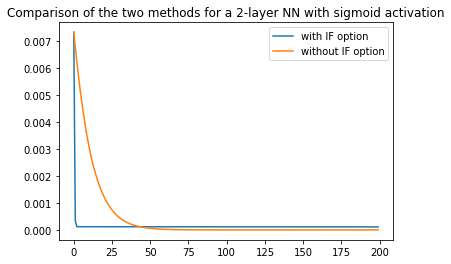

In [30]:
plt.plot(list(range(len(l1))),l1,label = "with IF option")
plt.plot(list(range(len(l2))),l2, label = "without IF option")
plt.legend()
plt.title("Comparison of the two methods for a 2-layer NN with sigmoid activation")
plt.savefig("2layers_exp2.png")